In [15]:

import torch
import numpy as np
import pandas as pd
from itertools import product
import matplotlib.pyplot as plt
import torch.nn.functional as F
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from mpl_toolkits.mplot3d import Axes3D
from collections import deque


%load_ext autoreload
%autoreload 2
from help_functions.make_conv_2d_torch import make_conv_2d_torch
from help_functions.make_conv_3d_torch import make_conv_3d_torch
from help_functions.morph_fill import morph_fill
from help_functions.Sub_AT_torch import Sub_AT_torch
from help_functions.Sub_A_torch import Sub_A_torch
from help_functions.solve_least_squares_subdivision import solve_least_squares_subdivision
from help_functions.plot_subdivision_points import plot_subdivision_points
from help_functions.solve_least_squares_subdivision import apply_C


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


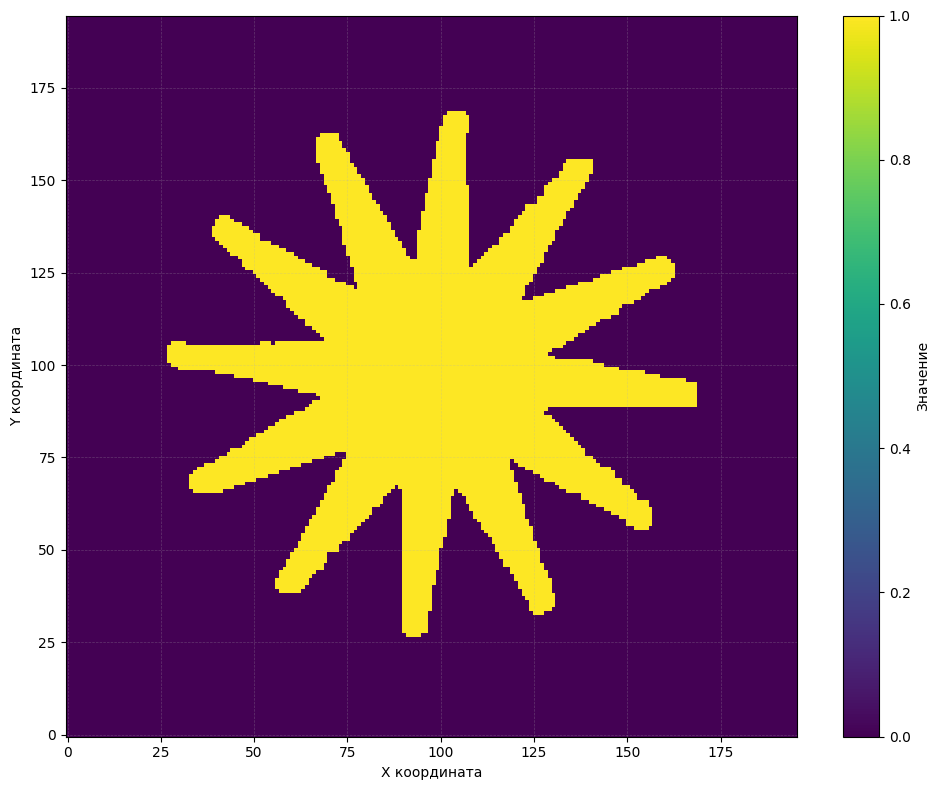

In [12]:
# Читаем файл и получаем изображение
coef = 3.5
raw_data = np.loadtxt('./models/Turbine.txt').reshape(-1)
int_cast_data = np.trunc(raw_data*coef*np.power(10,0)).astype(int).reshape(-1, 3)

shifted = (int_cast_data - int_cast_data.min(axis=0) + 1*np.array([10,10,10]))
sizes = (int_cast_data.max(axis=0) - int_cast_data.min(axis=0) + 1*np.array([20,20, 20])).astype(int)

tensor_3d = torch.zeros(tuple(sizes), dtype=int)
tensor_3d[shifted[:, 0], shifted[:, 1], shifted[:, 2]] = 1

#Берем срез
turbine_slice = tensor_3d[:,:, 55]

#Утолщаем границы единичной сверткой
kernel_shape = 3
turbine_slice_conv_result = make_conv_3d_torch(source=turbine_slice, kernel=torch.ones(size=(kernel_shape,kernel_shape,kernel_shape)))

#Морфологически заполняем срез
turbine_slice_conv_filled = morph_fill(turbine_slice_conv_result)

plt.figure(figsize=(10, 8))
    
plt.imshow(turbine_slice_conv_filled, 
           cmap='viridis', 
           aspect='auto',
           origin='lower')  

plt.colorbar(label='Значение')
plt.xlabel('X координата')
plt.ylabel('Y координата')

plt.grid(True, alpha=0.3, linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.savefig('./images/turbine_slice_conv_filled.png')
plt.show()


In [33]:
turbine_slice_conv_filled.shape

torch.Size([195, 196])

In [135]:
mask = torch.tensor([0, 1, 3, 3, 1], dtype=torch.float32) / 4

# Z - характористическая функция поверхности
Z = turbine_slice_conv_filled


x0 = solve_least_squares_subdivision(Z, mask)
z_rec = Sub_A_torch(mask, x0)

# error = torch.norm(z_rec - Z)
# print(error)

Shape of r torch.Size([98, 98])
ITER: 0, grad norm = 13.694171905517578
ITER: 1, grad norm = 6.188628196716309
ITER: 2, grad norm = 3.4845495223999023
ITER: 3, grad norm = 2.414431571960449
ITER: 4, grad norm = 1.6415224075317383
ITER: 5, grad norm = 1.277773141860962
ITER: 6, grad norm = 0.93954998254776
ITER: 7, grad norm = 0.7752277851104736
ITER: 8, grad norm = 0.5938459634780884
ITER: 9, grad norm = 0.5059699416160583
ITER: 10, grad norm = 0.39686527848243713
ITER: 11, grad norm = 0.3448117971420288
ITER: 12, grad norm = 0.27455833554267883
ITER: 13, grad norm = 0.2416454702615738
ITER: 14, grad norm = 0.19438844919204712
ITER: 15, grad norm = 0.17262902855873108
ITER: 16, grad norm = 0.13987863063812256
ITER: 17, grad norm = 0.1250269114971161
ITER: 18, grad norm = 0.10184485465288162
ITER: 19, grad norm = 0.09146826714277267
ITER: 20, grad norm = 0.07480470091104507
ITER: 21, grad norm = 0.06742770969867706
ITER: 22, grad norm = 0.05531205236911774
ITER: 23, grad norm = 0.049998

In [79]:
x0.shape

torch.Size([98, 98])

In [80]:
z_rec.shape

torch.Size([195, 195])

In [81]:
Z.shape

torch.Size([195, 196])

In [137]:
threshold = 0
x0_modified = torch.where(x0 > threshold, x0, torch.tensor(0.0))

In [118]:
x0_modified.shape

torch.Size([98, 98])

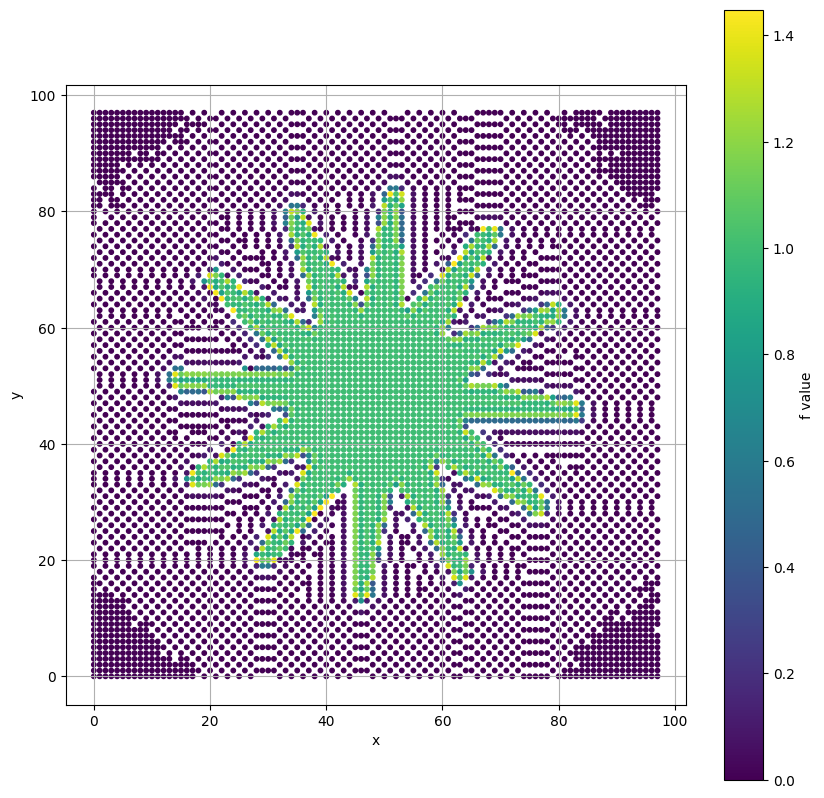

In [138]:
plot_subdivision_points(x0_modified, threshold=0, do_ceil=False)

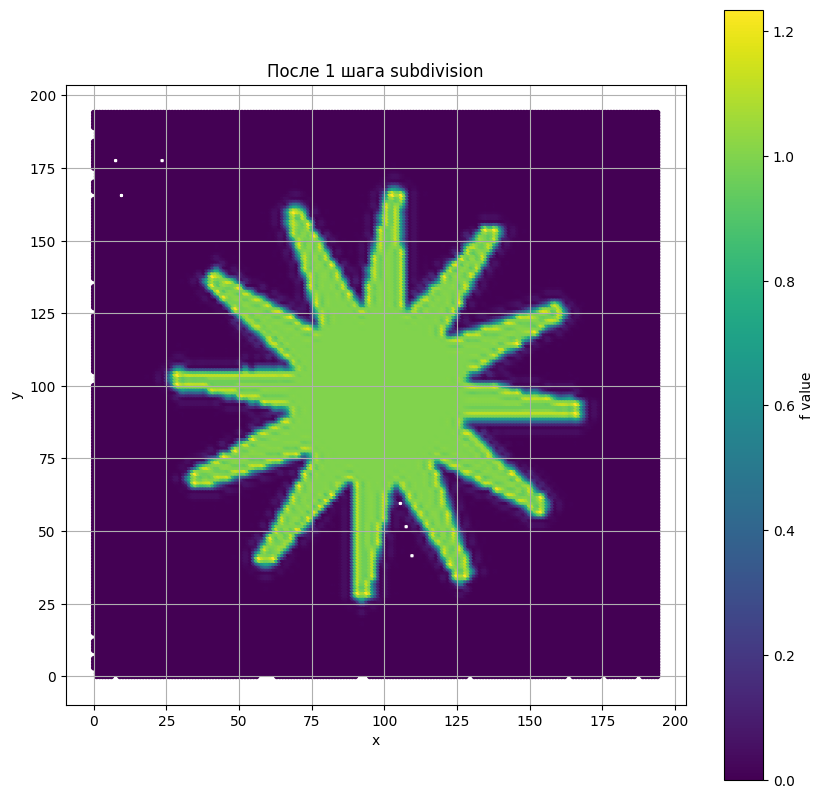

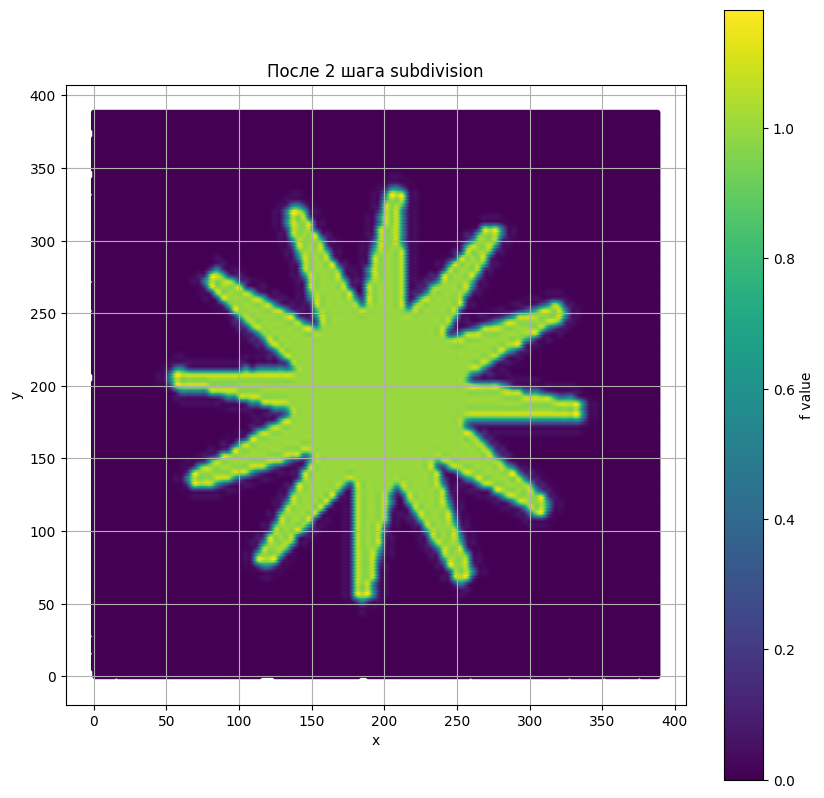

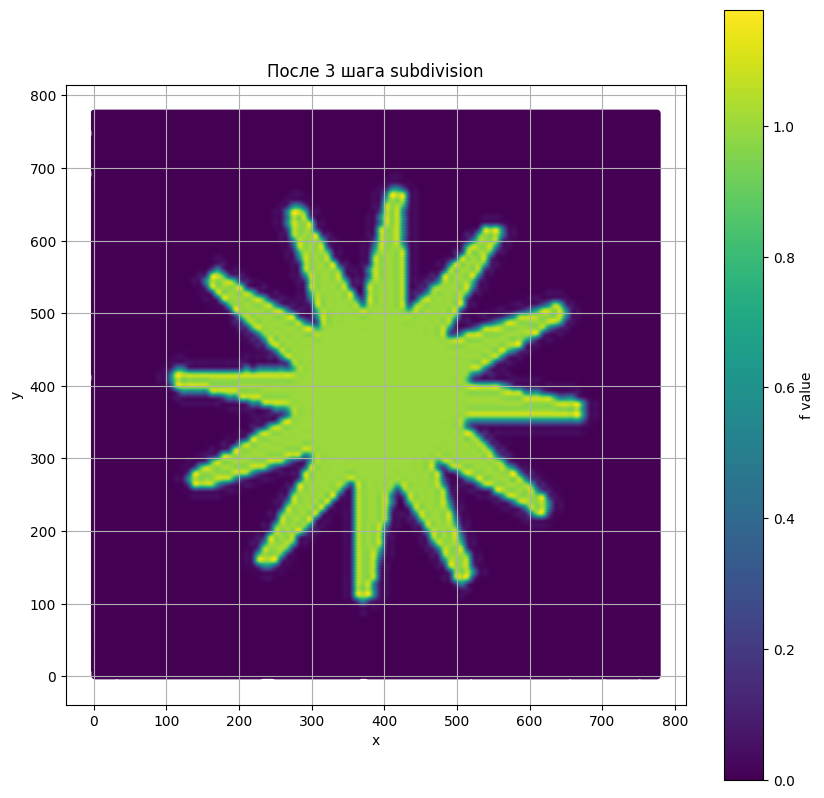

In [121]:

x0_clone = x0_modified.clone()
for i in range(3):
    x0_clone = Sub_A_torch(mask, x0_clone)
    plot_subdivision_points(
        x0_clone,
        threshold=0.00,
        title=f"После {i+1} шага subdivision",
        figsize=(10,10),
        do_ceil= False,
        visual_type= 'scatter'
    )

In [105]:
x0_clone.shape

torch.Size([777, 777])

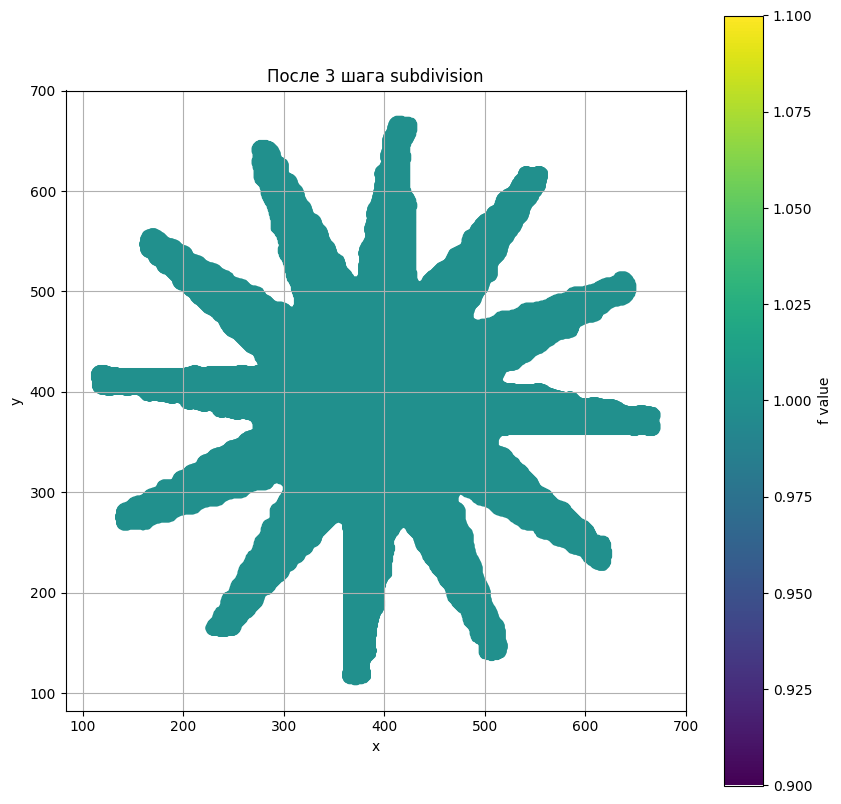

In [122]:
plot_subdivision_points(
        x0_clone,
        threshold=0.8,
        title=f"После {i+1} шага subdivision",
        figsize=(10,10),
        do_ceil= True,
        visual_type= 'scatter'
    )

In [55]:
a = torch.tensor([[1,2],[3,4]])
a

tensor([[1, 2],
        [3, 4]])

In [66]:
a[(slice(None, -1),) * a.ndim]

tensor([[1]])

In [65]:
tuple(slice(0, -1) for _ in range(a.ndim))

(slice(0, -1, None), slice(0, -1, None))